# RNN in Numpy

Recurrent Neural Networks (RNN) are a class of Artificial Neural Networks that is extremely well equiped to process a sequence of inputs. Therefore, RNNs are usefull in time series. 

In this work, I created a RNN from scratch using Numpy. This RNN is based on Andrej Karpathy's char-rnn and will be the basis for a LSTM network. This network will be used to classify protein locations based on the amino acid sequence.

In [1]:
# First import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
from module import Module

In [2]:
# Random seed
np.random.seed(420)

In [3]:
# Open the training data and save some important variables. If you want to train on your own text, just change the .txt file in the data variable.
#data = open('shakespeare.txt', 'r').read()
data = open('nescio.txt', 'r').read()
chars = list(set(data))
data_size = len(data)
vocab_size = len(chars)

In [4]:
print(f'Data set is length {data_size}')
print(f'Vocab set is length {vocab_size}')

Data set is length 201884
Vocab set is length 88


In [5]:
# Simple character embedding
char_to_idx = {char:i for i, char in enumerate(chars)}
idx_to_char = {i:char for i, char in enumerate(chars)}

In [6]:
# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1
epochs = 10

In [7]:
class RNN(Module):
    r""" Simple recurrent neural network (RNN) class for an input sequence.
    
        This RNN initializes weight and gradients. And contains the forward
        and backward pass. The network is optimized using Adagrad.
        The train method is used to train the network.
        
        Parameters
        ----------
        seq_len : Number of layers connected to each others. 
        hidden_sz : The number of features in the hidden state h.
        vocab_sz : The number of possible inputs and outputs.
        
        
        Inputs (train)
        --------------
        data : Data used to train the network.
        optimizer : The optimizer that is used to train the network.
        lr : The learning rate used to train the network.
        epochs : The number of epochs to train the network.
        progress : If True, shows the progress of training the network.
        
        Inputs (predict)
        ----------------
        start : Start of a sentence that the network uses as initial sequence.
        n : Length of the prediction.
        
        
        Output (train)
        --------------
        smooth_loss : The loss of the current trained network.
        Wxh, Whh, Why : Updated weights of the network due to training.
        bh, by : Updated biases due to training.
        
        Output (predict)
        ----------------
        txt : A string that is predicted by the RNN.
    
    """
    
    def __init__(self, seq_length, hidden_sz, vocab_sz):
        self.weight_params = ['Wxh', 'Whh', 'Why', 'Bh', 'By']
        self.hidden_params = ['hs']
        
        super().__init__(seq_length, hidden_sz, vocab_sz)
        
    def forward(self, xs, targets):
        """
        Forward pass of the RNN
        """
        
        y_preds = {}

        self.loss = 0

        for i in range(len(xs)):
            x = xs[i]
            x_vec = np.zeros((self.vocab_sz, 1)) # vectorize the input
            x_vec[x] = 1

            # Calculate the new hidden, which is based on the input and the previous hidden layer
            self.hidden['hs'][i] = np.tanh(np.dot(self.params['Wxh']['weight'], x_vec)
                                + np.dot(self.params['Whh']['weight'], self.hidden['hs'][i - 1]) 
                                + self.params['Bh']['bias'])
            # Predict y
            y_preds[i] = np.dot(self.params['Why']['weight'], self.hidden['hs'][i]) + \
            self.params['By']['bias'] 

            self.sm_ps[i] = np.exp(y_preds[i]) / np.sum(np.exp(y_preds[i])) # Softmax probabilty
            self.loss += -np.log(self.sm_ps[i][targets[i], 0]) #Negative loss likelyhood

        self.hidden['hs'][-1] = self.hidden['hs'][len(xs) - 1]
        
    def backward(self, xs, targets):
        """
        Backward pass of the RNN
        """
        self.init_grads()
    
        # Initialize empty next hidden layer for the first backprop
        dhnext = np.zeros_like(self.hidden['hs'][0])

        for i in reversed(range(len(xs))):
            # X to vector
            x = xs[i]    
            x_vec = np.zeros((vocab_size, 1))
            x_vec[x] = 1

            dy = np.copy(self.sm_ps[i])
            dy[targets[i]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here

            self.params['By']['grad'] += dy   
            self.params['Why']['grad'] += np.dot(dy, self.hidden['hs'][i].T)
            dh = np.dot(self.params['Why']['weight'].T, dy) + dhnext
            dhraw = (1 - self.hidden['hs'][i] * self.hidden['hs'][i]) * dh  
            self.params['Wxh']['grad'] += np.dot(dhraw, x_vec.T)
            self.params['Whh']['grad'] += np.dot(dhraw, self.hidden['hs'][i-1].T)
            self.params['Bh']['grad'] += dhraw
            dhnext = np.dot(self.params['Whh']['weight'].T, dhraw)

        # Clip to prevent exploding gradients
        for dparam in self.params.keys():
            np.clip(self.params[dparam]['grad'], -5, 5, out=self.params[dparam]['grad'])
    
    def predict(self, start, n):
        """
        Predict a sequence of text based on a starting string.
        """
        seed_idx = char_to_idx[start[-1]]
        x = np.zeros((self.vocab_sz, 1))
        x[seed_idx] = 1
        
        txt = [ch for ch in start]
        
        idxes = []
        
        h = self.hs[-1]
        
        for i in range(n):
            
            # Calculate the hidden
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            # Calculate y
            y = np.dot(self.Why, h) + self.by

            sm_p = np.exp(y) / np.sum(np.exp(y)) # Softmax probabilty
            # Determine character based on weighted probability (is using the softmax probability)
            idx = np.random.choice(range(self.vocab_sz), p=sm_p.ravel())
            idxes.append(idx)
            
            # Save X for next iteration
            x = np.zeros((self.vocab_sz, 1))
            x[idx] = 1
            
        prediction = [idx_to_char[idx] for idx in idxes]
        
        txt += prediction
        
        return txt

In [8]:
model = RNN(seq_length, hidden_size, vocab_size)

In [9]:
x_vec = np.zeros((vocab_size, 1))
x_vec.shape

(88, 1)

In [10]:
model.params

{'Wxh': {'size': (100, 88),
  'weight': array([[-0.00485391, -0.01905154, -0.00526222, ..., -0.00507615,
           0.00834463, -0.00087765],
         [-0.00249147, -0.00868852, -0.00179125, ..., -0.0009194 ,
           0.01060949,  0.00586886],
         [-0.00695594, -0.00277062,  0.00052576, ...,  0.00831669,
          -0.00409464, -0.00021401],
         ...,
         [-0.00128881, -0.02336164,  0.01104349, ..., -0.01047182,
          -0.00281494,  0.00425157],
         [ 0.03091146, -0.00769293,  0.00561186, ...,  0.00473466,
          -0.00444022,  0.01537137],
         [-0.0086582 , -0.00380412, -0.01462873, ...,  0.00960837,
          -0.00919343,  0.00801041]])},
 'Whh': {'size': (100, 100),
  'weight': array([[-0.00523443,  0.00347861, -0.0070323 , ..., -0.01101277,
           0.00245476, -0.006629  ],
         [ 0.00568726,  0.00646647,  0.00177553, ...,  0.0153292 ,
           0.00816958, -0.00172998],
         [-0.00625971, -0.02423122, -0.00721497, ...,  0.01343936,
       

In [11]:
model.train(data, 'Adagrad', learning_rate, 5)

Epoch 1: 0 / 8075: 111.93341382693228
Epoch 1: 1000 / 8075: 87.29552427891417
Epoch 1: 2000 / 8075: 71.03580244428632
Epoch 1: 3000 / 8075: 63.48451902196947
Epoch 1: 4000 / 8075: 60.484837292131964
Epoch 1: 5000 / 8075: 59.54680232755414
Epoch 1: 6000 / 8075: 58.03603034708285
Epoch 1: 7000 / 8075: 56.787463948815876
Epoch 1: 8000 / 8075: 56.30665563432349
Epoch 2: 0 / 8075: 56.330019307220454
Epoch 2: 1000 / 8075: 55.35972274581032
Epoch 2: 2000 / 8075: 54.72099180228336
Epoch 2: 3000 / 8075: 53.967215948451205
Epoch 2: 4000 / 8075: 54.00061011954101
Epoch 2: 5000 / 8075: 54.40594244583087
Epoch 2: 6000 / 8075: 53.961747591794904
Epoch 2: 7000 / 8075: 53.21675020611554
Epoch 2: 8000 / 8075: 53.28187533721917
Epoch 3: 0 / 8075: 53.331926141142745
Epoch 3: 1000 / 8075: 52.79328887743293
Epoch 3: 2000 / 8075: 52.54805217401462
Epoch 3: 3000 / 8075: 51.99386286539712
Epoch 3: 4000 / 8075: 52.07627193657172
Epoch 3: 5000 / 8075: 52.49144672895021
Epoch 3: 6000 / 8075: 52.23956374237655
Ep

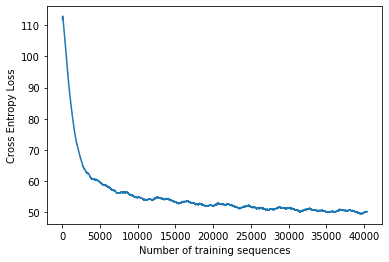

In [12]:
model.plot_losses()

In [13]:
prediction = model.predict('Gefeliciteerd', 50)
print(''.join(prediction))

AttributeError: 'RNN' object has no attribute 'hs'

References:
* Fundamentals of Recurrent Neural Network (RNN) and Long Short-Term Memory (LSTM) Network 	Elsevier "Physica D: Nonlinear Phenomena" journal, Volume 404, March 2020: Special Issue on Machine Learning and Dynamical Systems (DOI: 	10.1016/j.physd.2019.132306)
* https://www.kdnuggets.com/2020/07/rnn-deep-learning-sequential-data.html
* https://gist.github.com/karpathy/d4dee566867f8291f086